In [65]:
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator

In [66]:
def plot_steps(data):
    for runIdx in range(0, len(data)):
        fig, ax = plt.subplots()
        iteration = data.iloc[runIdx]["iteration"]
        clusters = data.iloc[runIdx]["clusters"]
        norm = colors.Normalize(vmin=0, vmax=len(clusters))
        print("iteration: %s, clusters: %s" % (iteration, len(clusters)))
        for cIdx in range(0, len(clusters)):
            rgba_color = cm.gnuplot(norm(cIdx))
            pointsX = [point[0] for point in clusters[cIdx]["points"]]
            pointsY = [point[1] for point in clusters[cIdx]["points"]]
            ax.scatter(pointsX, pointsY, color=rgba_color)
            ax.scatter(clusters[cIdx]["centroid"][0], clusters[cIdx]["centroid"][1], color=rgba_color, marker="+")

        plt.show()

In [67]:
def plot(data):
    for runIdx in range(0, len(data)):
        fig, ax = plt.subplots()
        clusters_step1 = data.iloc[runIdx]["steps"][0]["clusters"]
        clusters_step2 = data.iloc[runIdx]["steps"][1]["clusters"]
        norm = colors.Normalize(vmin=0, vmax=len(clusters_step1))
        for cIdx in range(0, len(clusters_step1)):
            rgba_color = cm.gnuplot(norm(cIdx))
            ax.plot(clusters_step1[cIdx]["syntheticCenter"], "--", color=rgba_color, label="cluster %s" % cIdx)
            ax.plot(clusters_step2[cIdx]["syntheticCenter"], color=rgba_color, label="cluster %s - rescheduled" % cIdx)
            print(clusters_step2[cIdx]["metric"])
        ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)

        ax.set(xlabel='Hours', ylabel='Power (kW)',title='')
        plt.show()

In [68]:
def plot_aggm(summary, file_name=None): 
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. agg m"], "--", color=rgba_color, label="s1. agg m")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. agg m"], color=rgba_color, label="s2. agg m")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Aggregate PAR',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig
    
def plot_maxm(summary, file_name=None): 
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. max m"], "--", color=rgba_color, label="s1. max m")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. max m"], color=rgba_color, label="s2. max m")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Max. Aggregate PAR',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig
    
def plot_peak(summary, file_name=None):
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. peak"], "--", color=rgba_color, label="s1. peak")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. peak"], color=rgba_color, label="s2. peak")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Peak power (kW)',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig

# PAR Aggregate

In [69]:
summaryBatch_global = pd.read_json("./files/scheduler_tests/scheduler_test/summaryBatch.json")
#summaryBatch_global = summaryBatch_global[["k","clusters","s1. agg m","s1. max m","s1. peak","s2. agg m","s2. max m","s2. peak","total m"]]
#batch_global = pd.read_json("./files/batch.json")

exp1_k = 6
exp1_sample_size_min = 0.5
exp1_sample_size_max = 1.0
exp1_nsteps = 2


def sample_size_range(sample_size_min, sample_size_max):
    return (x/10 for x in range(int(sample_size_min * 10), int((sample_size_max * 10) + 1)))

In [70]:
def crossfold_as_df(k, data):
    index_list = []
    step_list = []

    for i in range(0 , len(data)):
        register = data.iloc[i]

        crossfold = json_normalize(register["crossfold"])
        splits = crossfold["splits"].values[0]
        steps = data.iloc[i]["step"]
        for j in range(0, splits):
            step = json_normalize(steps[j])
            for ki in range(1, k+1):
                index_list.append((float("{0:.2f}".format(crossfold["sampleSize"].values[0])), j, ki))
                step_list.append(step.iloc[ki-1])


    json_normalize(data.iloc[0]["crossfold"])
    json_normalize(data.iloc[0]["step"][0])

    index = pd.MultiIndex.from_tuples(index_list, names=["sampleSize", "split", "k"])
    return pd.DataFrame(step_list, index=index)
exp1_treated = crossfold_as_df(exp1_k, summaryBatch_global)
exp1_treated

k  s1. peak  s1. agg m  s1. max m  s1. total m  \
sampleSize split k                                                   
0.5        0     1  1    608641   2.298238   2.298238     2.298238   
                 2  2    315383   1.006124   2.355152     2.298238   
                 3  3    369688   1.029584   2.711698     2.298238   
                 4  4    307607   1.043860   2.912795     2.298238   
                 5  5    234551   1.053113   3.047728     2.298238   
...                ..       ...        ...        ...          ...   
1.0        2     2  2    662426   1.000673   1.983138     1.965393   
                 3  3    476413   1.045340   2.176385     1.965393   
                 4  4    406690   1.061735   2.261160     1.965393   
                 5  5    387908   1.046434   2.349815     1.965393   
                 6  6    301408   1.075226   2.579912     1.965393   

                              clusters  s2. peak  s2. agg m  s2. max m  \
sampleSize split k                                                       
0.5        0     1                [25]    561639   2.120758   2.120758   
                 2            [13, 12]    315383   1.078225   2.355152   
                 3          [13, 7, 5]    361869   1.015177   2.654345   
                 4       [10, 9, 4, 2]    299788   1.122947   2.904704   
                 5     [8, 8, 3, 4, 2]    205244   1.153837   3.303985   
...                                ...       ...        ...        ...   
1.0        2     2            [23, 27]    782371   1.092681   2.342224   
                 3        [14, 18, 18]    541417   1.029541   2.168268   
                 4     [14, 16, 8, 12]    489000   1.344621   3.412924   
                 5   [10, 13, 9, 9, 9]    406383   1.158881   2.659162   
                 6  [8, 8, 9, 7, 9, 9]    308088   1.127413   2.580744   

                    s2. total m  
sampleSize split k               
0.5        0     1     2.120758  
                 2     2.120758  
                 3     2.120758  
                 4     2.120758  
                 5     2.120758  
...                         ...  
1.0        2     2     1.842278  
                 3     1.842278  
                 4     1.842278  
                 5     1.842278  
                 6     1.842278  

[108 rows x 10 columns]

In [80]:
k2 = 2
query = f"k == {k2} and sampleSize == {exp1_sample_size_min}"
exp1_treated.query(query)["s1. agg m"].mean()
exp1_treated.query(query)["s1. max m"].mean()
exp1_treated.query(query)["s1. peak"].std()

61602.06428629915

In [72]:
def get_statistics(k, nSteps, treated, sample_size_min, sample_size_max):
    index_list = []
    step_list = []

    for j in range(1, k+1):
        for ssize in sample_size_range(sample_size_min, sample_size_max):

            index_list.append((ssize, "mean", j))
            query = f"k == {j} and sampleSize == {ssize}"
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m"]
            data = {key: treated.query(query)[key].mean() for key in index}
            data = {"s1. agg m" : treated.query(query)["s1. agg m"].mean(),
                    "s1. max m" : treated.query(query)["s1. max m"].mean(), 
                    "s1. peak" : treated.query(query)["s1. peak"].mean()/1000,
                   "s1. total m" : treated.query(query)["s1. total m"].mean()}
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m"]
            if (nSteps >= 2):
                data.update({"s2. agg m" : treated.query(query)["s2. agg m"].mean(),
                    "s2. max m" : treated.query(query)["s2. max m"].mean(), 
                    "s2. peak" : treated.query(query)["s2. peak"].mean()/1000,
                            "s2. total m" : treated.query(query)["s2. total m"].mean()})
                index = index + ["s2. agg m","s2. max m","s2. peak", "s2. total m"]

            s = pd.Series(data,index=index) 
            step_list.append(s)
            #print(f"sampleSize = {ssize}, k = {j}")

            index_list.append((ssize, "stdv", j))
            query = f"k == {j} and sampleSize == {ssize}"
            data = {"s1. agg m" : treated.query(query)["s1. agg m"].std(),
                    "s1. max m" : treated.query(query)["s1. max m"].std(), 
                    "s1. peak" : treated.query(query)["s1. peak"].std(),
                   "s1. total m" : treated.query(query)["s1. total m"].std()}
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m"]
            if (nSteps >= 2):
                data.update({"s2. agg m" : treated.query(query)["s2. agg m"].std(),
                    "s2. max m" : treated.query(query)["s2. max m"].std(), 
                    "s2. peak" : treated.query(query)["s2. peak"].std(),
                            "s2. total m" : treated.query(query)["s2. total m"].std()})
                index = index + ["s2. agg m","s2. max m","s2. peak", "s2. total m"]

            s = pd.Series(data,index=index) 
            step_list.append(s)


    index = pd.MultiIndex.from_tuples(index_list, names=["sampleSize", "metric", "k"])
    return pd.DataFrame(step_list, index=index)
exp1_statistics = get_statistics(exp1_k,exp1_nsteps, exp1_treated, exp1_sample_size_min, exp1_sample_size_max)
exp1_statistics

s1. agg m  s1. max m      s1. peak  s1. total m  \
sampleSize metric k                                                    
0.5        mean   1   2.179059   2.179059    685.141667     2.179059   
           stdv   1   0.162170   0.162170  82692.377069     0.162170   
0.6        mean   1   2.045974   2.045974    767.186667     2.045974   
           stdv   1   0.225997   0.225997  71594.055705     0.225997   
0.7        mean   1   2.002926   2.002926    844.865667     2.002926   
...                        ...        ...           ...          ...   
0.8        stdv   6   0.017958   0.112746  46036.339400     0.081809   
0.9        mean   6   1.073858   2.537169    293.854333     1.980994   
           stdv   6   0.022952   0.185988  35693.092292     0.102132   
1.0        mean   6   1.082752   2.591940    319.850667     1.965393   
           stdv   6   0.009335   0.052235  53176.299291     0.000000   

                     s2. agg m  s2. max m      s2. peak   s2. total m  
sampleSize metric k                                                    
0.5        mean   1   1.996806   1.996806    627.403333  1.996806e+00  
           stdv   1   0.138130   0.138130  67310.936365  1.381296e-01  
0.6        mean   1   1.913032   1.913032    716.042667  1.913032e+00  
           stdv   1   0.255591   0.255591  65551.477331  2.555907e-01  
0.7        mean   1   1.785477   1.785477    754.651667  1.785477e+00  
...                        ...        ...           ...           ...  
0.8        stdv   6   0.055636   0.113495  22267.966282  1.086947e-01  
0.9        mean   6   1.345310   3.369881    386.851667  1.885210e+00  
           stdv   6   0.112181   0.303817  76068.401826  3.388785e-02  
1.0        mean   6   1.093536   2.592218    344.962000  1.842278e+00  
           stdv   6   0.030122   0.052142  90845.644975  2.719480e-16  

[72 rows x 8 columns]

In [87]:
def get_metrics(k, metric, metric_type, statistics, sample_size_min, sample_size_max):

    index_list = [sample_size_range(sample_size_min, sample_size_max)]
    cols = [x for x in range(1, k+1)]
    step_list = []

    for ssize in sample_size_range(sample_size_min, sample_size_max):
        query = f"sampleSize == {ssize} and metric == \"{metric_type}\" "
        dataAllK = statistics.query(query)[f"{metric}"]
        dictAllK = {}
        for j in range(1, k+1):
            d = dataAllK.reset_index().query(f"k == {j}")[f"{metric}"]
            dictAllK[f"{j}"] = d.values[0]
        s = pd.Series(dictAllK, name=f"{ssize}")
        step_list.append(s)

    return pd.DataFrame(step_list)
    
mname = "s1. max m"
mtype = "stdv"
m = get_metrics(exp1_k, mname, mtype, exp1_statistics, exp1_sample_size_min, exp1_sample_size_max)

In [88]:
m

,1,2,3,4,5,6
0.5,0.162170,0.068516,0.160797,0.081181,0.038377,0.069137
0.6,0.225997,0.093630,0.209656,0.088739,0.024661,0.133419
0.7,0.174396,0.169991,0.088119,0.225919,0.065792,0.115129
0.8,0.081809,0.066225,0.058252,0.049782,0.101059,0.112746
0.9,0.102132,0.068430,0.023349,0.071196,0.074610,0.185988
1.0,0.000000,0.018407,0.048474,0.038135,0.038969,0.052235


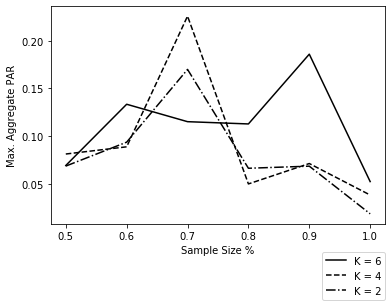

In [75]:
fig, ax = plt.subplots()

k2 = 6
sampleMaxMDataset = m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values = sampleMaxMDataset.values
ax.plot(sampleSizes, values, "-", label=f"K = {k2}", c="black")

k2 = 4
sampleMaxMDataset = m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values = sampleMaxMDataset.values
ax.plot(sampleSizes, values, "--", label=f"K = {k2}", c="black")

k2 = 2
sampleMaxMDataset = m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values = sampleMaxMDataset.values
ax.plot(sampleSizes, values, "-.", label=f"K = {k2}", c="black")

lgd = ax.legend(bbox_to_anchor=(1, -0.35), loc=4, borderaxespad=0.)
ax.set(xlabel='Sample Size %', ylabel='Max. Aggregate PAR',title='')
plt.show()
file_name = "peakpower_samplesize.pdf"
if file_name is not None:
    fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')


In [85]:
def show_summary(k, summary_treated, statistics):
    _list = {}
    for j in range(1, k+1):
        _list[j - 1] = str(summary_treated.query(f"sampleSize == 1.0 and k == {j}").sort_values(by=["s1. max m", "s1. agg m"]).iloc[0]["clusters"])
    _list
    a = statistics.query("sampleSize == 1.0 and metric == \"mean\"").reset_index().drop(["sampleSize", "metric"], axis=1)
    b = pd.DataFrame.from_dict(_list, orient="index", columns=["clusters"])
    r = pd.concat([a,b], axis=1, sort=False)
    r = r[["k", "clusters", "s1. agg m", "s1. max m", "s1. peak", "s2. agg m", "s2. max m", "s2. peak", "s2. total m"]]
    return r

show_summary(exp1_k, exp1_treated, exp1_statistics)

,k,clusters,s1. agg m,s1. max m,s1. peak,s2. agg m,s2. max m,s2. peak,s2. total m
0,1,[50],1.965393,1.965393,1224.687000,1.842278,1.842278,1147.971000,1.842278
1,2,"[37, 13]",1.005462,1.991948,767.067333,1.082326,2.248291,832.803333,1.842278
2,3,"[11, 19, 20]",1.028519,2.195739,551.959333,1.034534,2.161615,541.999667,1.842278
3,4,"[14, 14, 15, 7]",1.049092,2.226952,374.273333,1.187269,2.746724,413.839667,1.842278
4,5,"[10, 13, 9, 9, 9]",1.060057,2.391657,341.285000,1.127477,2.536946,371.394000,1.842278
5,6,"[8, 12, 7, 9, 8, 6]",1.082752,2.591940,319.850667,1.093536,2.592218,344.962000,1.842278


In [86]:
get_metrics(exp1_k, "s1. agg m", "mean", exp1_statistics, exp1_sample_size_min, exp1_sample_size_max).iloc[-1]

1    1.965393
2    1.005462
3    1.028519
4    1.049092
5    1.060057
6    1.082752
Name: 1.0, dtype: float64

In [79]:
with open('summaryBatch.tex','w') as tf:
    tf.write(r.to_latex())